In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import math

plt.style.use('default')


In [2]:
knn_results_hepatitis = pd.read_csv("../data/per_fold_results/knn_hepatitis.csv")
# knn_results_mushroom = pd.read_csv("../data/per_fold_results/knn_mushroom.csv")
knn_reduction_results_hepatitis = pd.read_csv("../data/per_fold_results/knn_reduction_hepatitis.csv")
# knn_reduction_results_mushroom = pd.read_csv("../data/per_fold_results/knn_reduction_mushroom.csv")
svm_results_hepatitis = pd.read_csv("../data/per_fold_results/svm_hepatitis.csv")
# svm_results_mushroom = pd.read_csv("../data/per_fold_results/svm_mushroom.csv")

In [3]:
fold_cols = [f'fold{i}' for i in range(1, 11)]

for df in [knn_results_hepatitis, knn_reduction_results_hepatitis, svm_results_hepatitis]:
    df['mean_f1_score'] = df.loc[:, fold_cols].mean(axis=1)
    df['std_f1_score'] = df.loc[:, fold_cols].std(axis=1)


In [4]:
def friedman_test(df_with_f1_per_fold):
    results = {
        i: df_with_f1_per_fold.loc[i, fold_cols] for i in df_with_f1_per_fold.index
    }
    f1_df = pd.DataFrame(results)
    statistic, p_value = stats.friedmanchisquare(*[f1_df[k] for k in f1_df])
    return statistic, p_value

def linear_sample(df_with_f1_per_fold, num_samples=8):
    num_samples = min(num_samples, len(df_with_f1_per_fold))
    samples_indices = np.linspace(0, len(df_with_f1_per_fold)-1, num_samples, dtype=int)
    return df_with_f1_per_fold.loc[samples_indices, :]

def top_samples(df_with_f1_per_fold, num_samples=8):
    num_samples = min(num_samples, len(df_with_f1_per_fold))
    return df_with_f1_per_fold.sort_values(by='mean_f1_score', ascending=False).head(num_samples)

friedman_test(linear_sample(svm_results_hepatitis))

(np.float64(32.687407407407385), np.float64(3.0272403715178655e-05))

In [5]:
num_sample_options = [4, 8, 16]
sample_types = ['linear', 'top']
models = ['KNN', 'SVM', 'KNN-Reduction']
dataframes = [knn_results_hepatitis, svm_results_hepatitis, knn_reduction_results_hepatitis]
data = []

for sample_type, num_samples, (model, df) in itertools.product(sample_types, num_sample_options, zip(models, dataframes)):
    sample_func = linear_sample if sample_type == 'linear' else top_samples
    
    p_value = friedman_test(sample_func(df, num_samples))[1]
    data.append({
        'model': model,
        'num_samples': num_samples,
        'sample_type': sample_type,
        'p_value': p_value,
        'significant': p_value < 0.05
    })

p_values_df = pd.DataFrame(data)

p_values_df

,model,num_samples,sample_type,p_value,significant
0,KNN,4,linear,1.009070e-01,False
1,SVM,4,linear,1.439571e-03,True
2,KNN-Reduction,4,linear,6.715252e-02,False
3,KNN,8,linear,5.837940e-06,True
4,SVM,8,linear,3.027240e-05,True
5,KNN-Reduction,8,linear,6.715252e-02,False
6,KNN,16,linear,8.320052e-11,True
7,SVM,16,linear,6.589008e-09,True
8,KNN-Reduction,16,linear,6.715252e-02,False
9,KNN,4,top,8.012520e-01,False


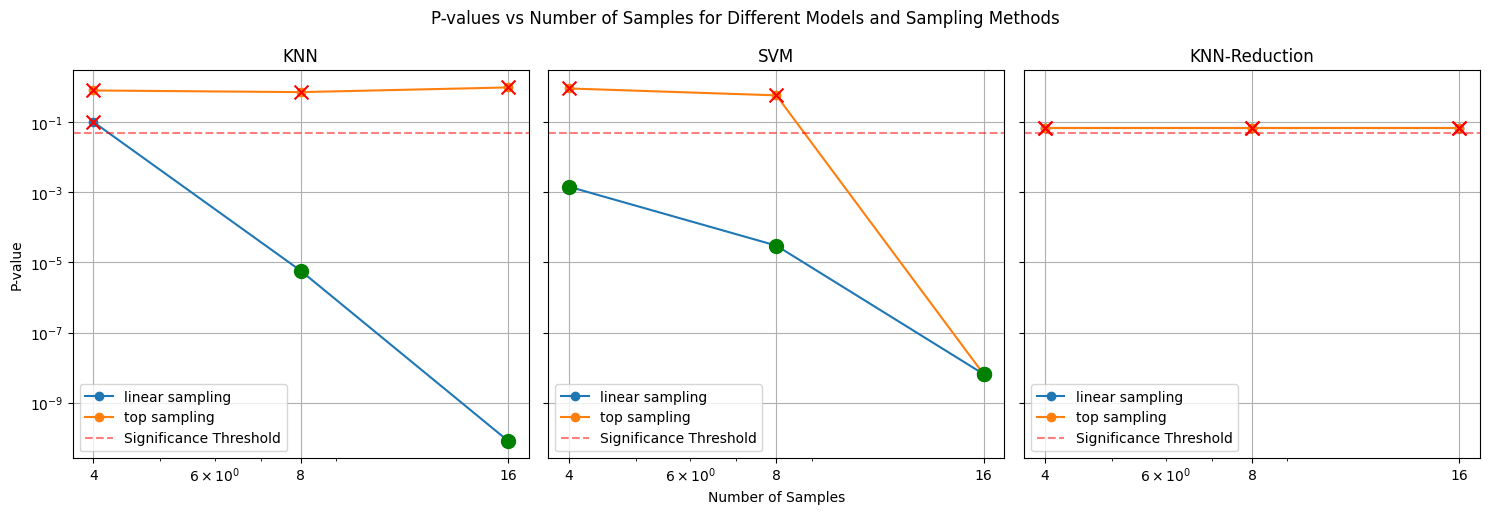

In [6]:
# TODO: only plot one point for KNN-Reduction

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
fig.suptitle('P-values vs Number of Samples for Different Models and Sampling Methods')

for idx, model in enumerate(models):
    model_data = p_values_df[p_values_df['model'] == model]
    
    for sample_type in sample_types:
        data = model_data[model_data['sample_type'] == sample_type]
        
        # Plot the line
        axes[idx].plot(data['num_samples'], data['p_value'], marker='o', label=f"{sample_type} sampling")
        
        # Scatter significant points (green circle)
        significant = data[data['significant']]
        axes[idx].scatter(significant['num_samples'], significant['p_value'], 
                          color='green', marker='o', s=100, zorder=3)
        
        # Scatter non-significant points (red x)
        non_significant = data[~data['significant']]
        axes[idx].scatter(non_significant['num_samples'], non_significant['p_value'], 
                          color='red', marker='x', s=100, zorder=3)
    
    axes[idx].set_title(f'{model}')
    if idx == 0:  # Only show y-label for first subplot
        axes[idx].set_ylabel('P-value')
    axes[idx].set_yscale('log')  # Log scale for y-axis
    axes[idx].set_xscale('log')  # Log scale for x-axis
    axes[idx].set_xticks(num_sample_options)
    axes[idx].set_xticklabels(num_sample_options)
    axes[idx].axhline(y=0.05, color='r', linestyle='--', alpha=0.5, label='Significance Threshold')  # Add significance threshold line
    axes[idx].grid(True)
    axes[idx].legend()

plt.tight_layout()
axes[len(axes)//2].set_xlabel('Number of Samples')
fig.savefig('../reports/figures/p_values_vs_num_samples.png', dpi=300)
plt.show()

In [7]:
# Create visualization for main effects
def plot_independent_effects(df, col_names):
    rows = math.ceil(len(col_names)/2)
    fig, axes = plt.subplots(rows, 2, figsize=(8, 4*rows))
    
    for ax, col_name in zip(axes.flatten(), col_names):
        sns.boxplot(data=df, x=col_name, y='mean_f1_score', ax=ax)
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
        ax.set_title(f"Effect of {col_name}")
        ax.set_ylabel('Mean F1 Score')
        ax.set_xlabel('')
    
    plt.tight_layout()
    return fig

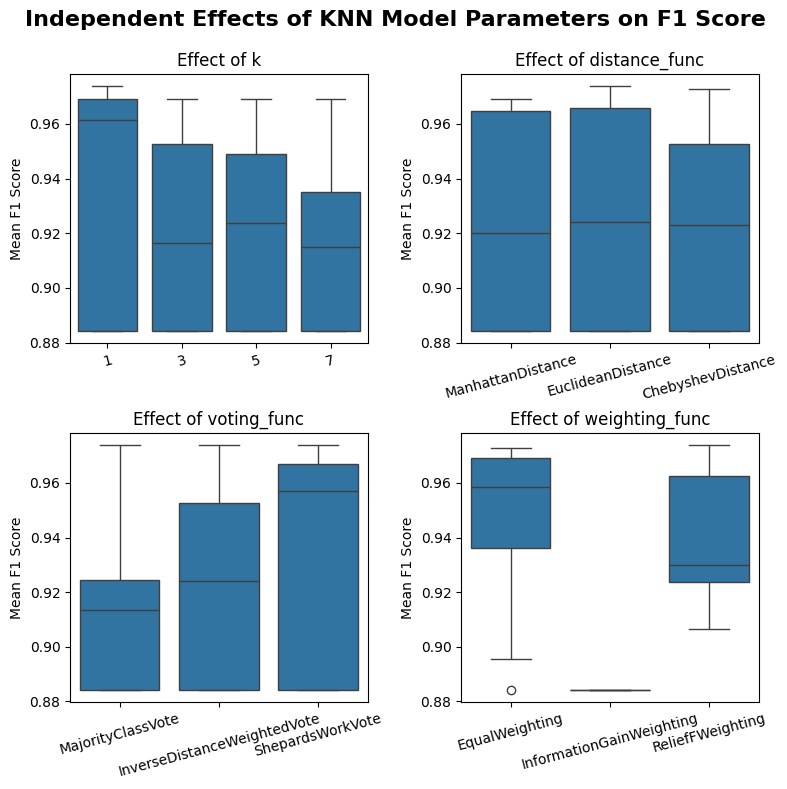

In [8]:
fig = plot_independent_effects(knn_results_hepatitis, ['k', 'distance_func', 'voting_func', 'weighting_func'])
fig.suptitle('Independent Effects of KNN Model Parameters on F1 Score', fontsize=16, fontweight='bold')
fig.subplots_adjust(top=0.9)
fig.savefig('../reports/figures/independent_effects_KNN.png', dpi=300)
plt.show()


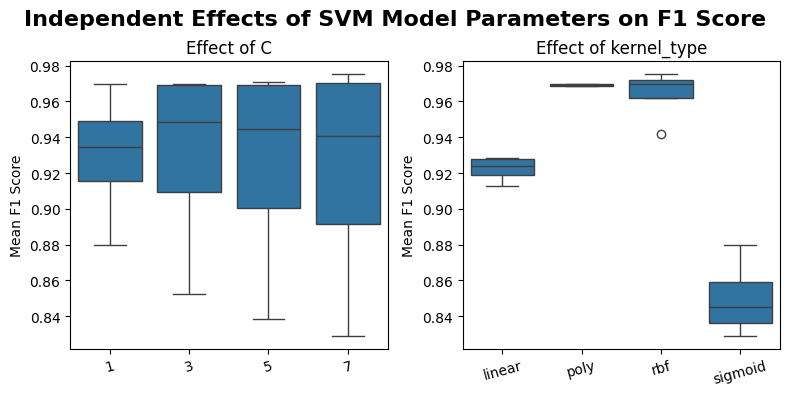

In [9]:
fig = plot_independent_effects(svm_results_hepatitis, ['C', 'kernel_type'])
fig.suptitle('Independent Effects of SVM Model Parameters on F1 Score', fontsize=16, fontweight='bold')
fig.subplots_adjust(top=0.85)
fig.savefig('../reports/figures/independent_effects_SVM.png', dpi=300)
plt.show()

In [10]:
def plot_interactions(df, col_names):
    num_cols = len(col_names)
    fig, axes = plt.subplots(num_cols, num_cols, figsize=(4*num_cols, 4*num_cols))
    
    # Make axes 2D if it's 1D
    if num_cols == 1:
        axes = np.array([[axes]])
    elif num_cols == 2:
        axes = np.array([[axes[0]], [axes[1]]])

    for i, ((col_name1, col_name2), ax) in enumerate(zip(itertools.product(col_names, repeat=2), axes.flatten())):
        if col_name1 == col_name2:
            # Diagonal plots: show distribution for single variable
            sns.boxplot(data=df, x=col_name1, y='mean_f1_score', ax=ax)
        else:
            # Off-diagonal plots: show interaction between variables
            pivot_table = df.pivot_table(
                values='mean_f1_score',
                index=col_name1,
                columns=col_name2,
                aggfunc='mean'
            )
            sns.heatmap(pivot_table, ax=ax, cmap='coolwarm', annot=True, fmt='.3f', cbar=False)
            
        # Remove all ticks initially
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')

    # Add row labels and y-ticks only on the leftmost plots
    for i in range(num_cols):
        if i == 0:  # First row special case
            axes[i, 0].set_ylabel(col_names[i], fontsize=20, rotation=90)
        else:
            axes[i, 0].set_ylabel(col_names[i], fontsize=20, rotation=90)
            axes[i, 0].set_yticks(np.arange(len(df[col_names[i]].unique())) + 0.5)
            axes[i, 0].set_yticklabels(df[col_names[i]].unique(), rotation=15)

    # Add column labels and x-ticks only on the bottom plots
    for j in range(num_cols):
        if j == num_cols - 1:
            axes[-1, j].set_xticks(np.arange(len(df[col_names[j]].unique())))
        else:
            axes[-1, j].set_xticks(np.arange(len(df[col_names[j]].unique())) + 0.5)
        axes[-1, j].set_xticklabels(df[col_names[j]].unique(), rotation=15)
    
    plt.tight_layout()
    return fig

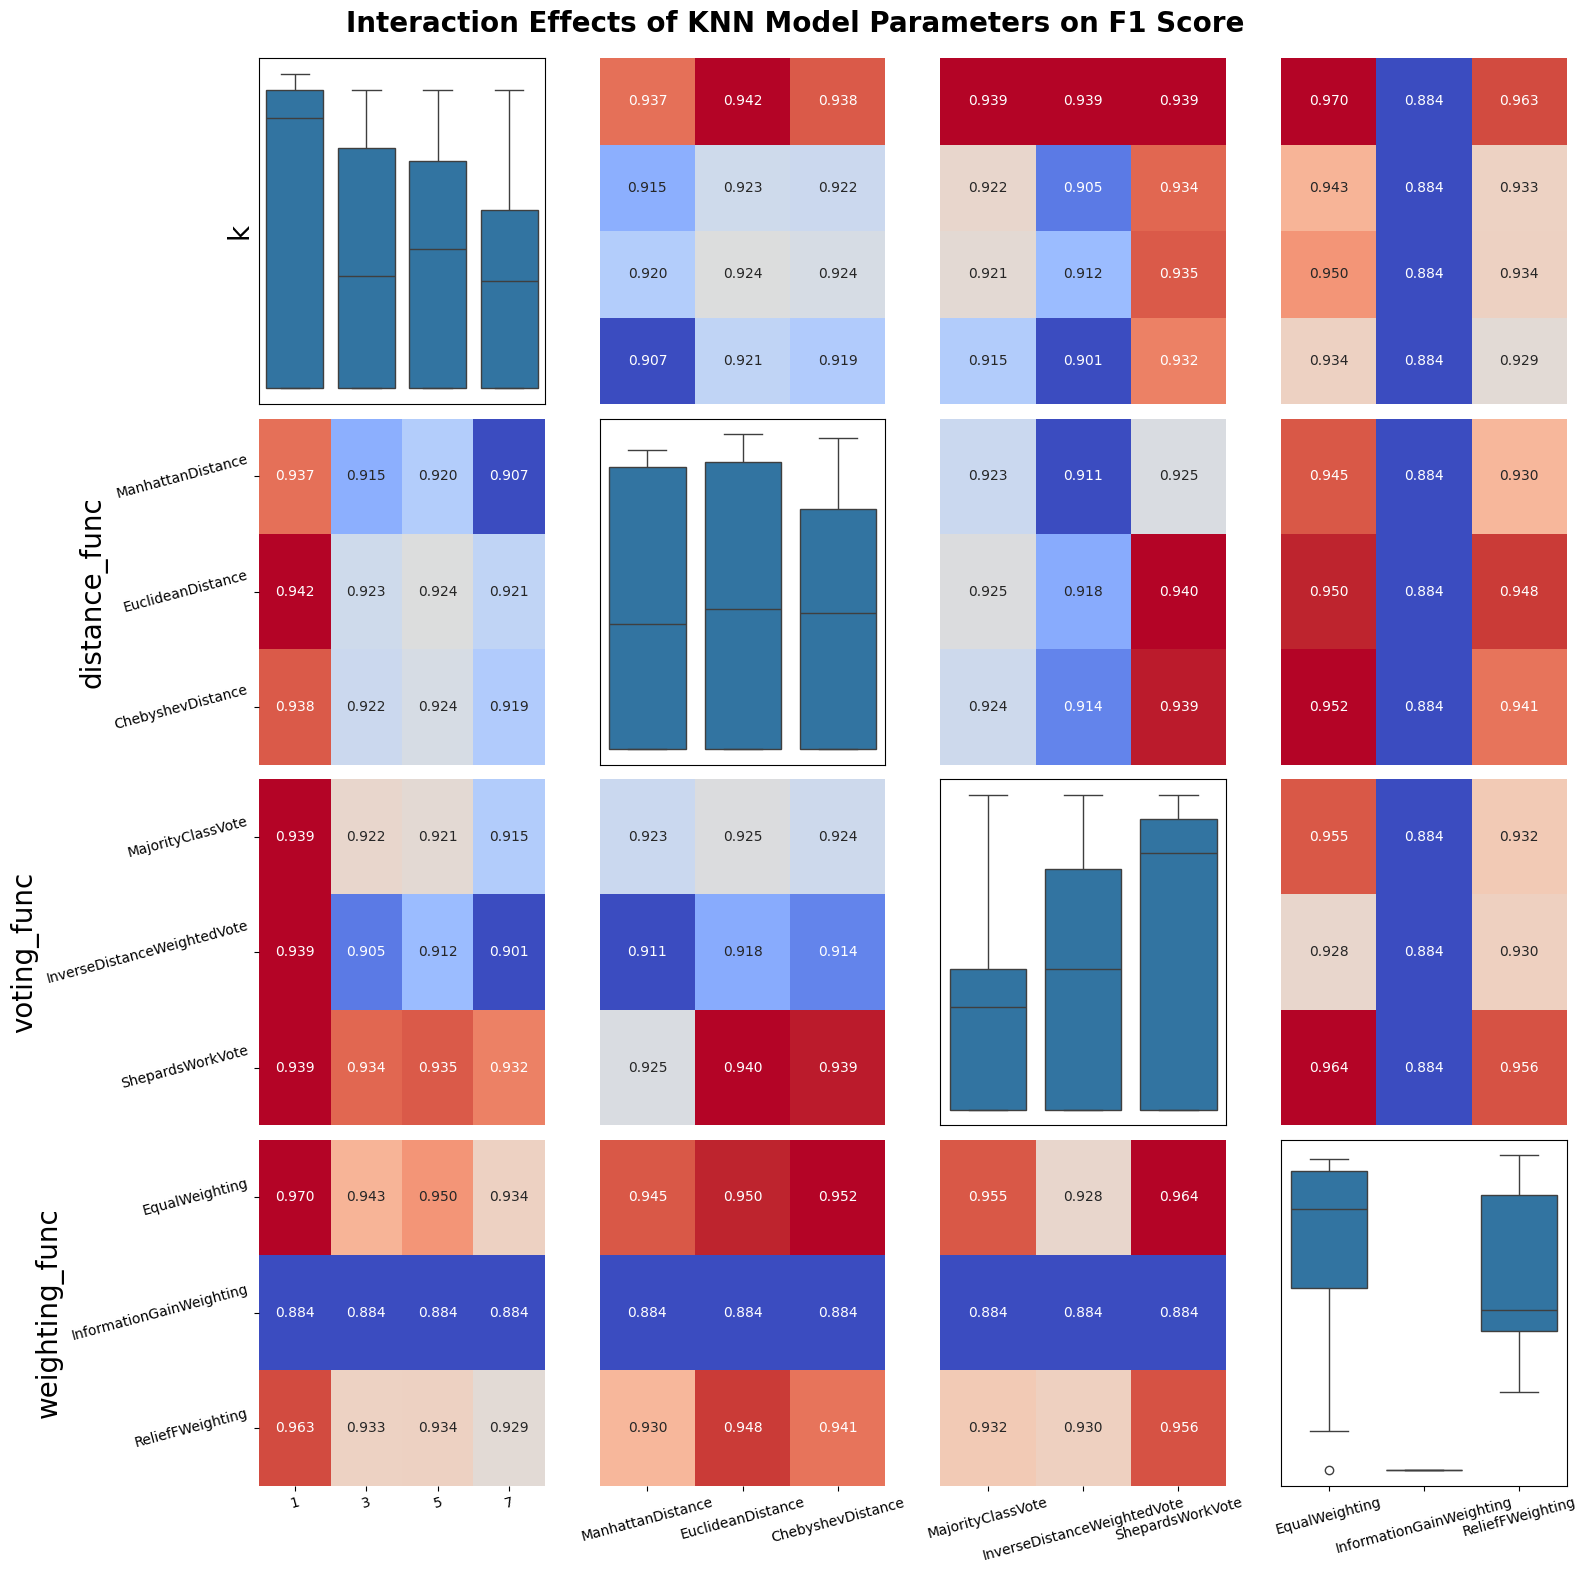

In [11]:
fig = plot_interactions(knn_results_hepatitis, ['k', 'distance_func', 'voting_func', 'weighting_func'])
fig.suptitle('Interaction Effects of KNN Model Parameters on F1 Score', fontsize=20, fontweight='bold')
fig.subplots_adjust(top=0.95)
fig.savefig('../reports/figures/interaction_effects_KNN.png', dpi=300)
plt.show()


In [12]:
def nemenyi_test(df_with_f1_per_fold):
    results = {
        i: df_with_f1_per_fold.loc[i, fold_cols] for i in df_with_f1_per_fold.index
    }
    f1_df = pd.DataFrame(results)
    return sp.posthoc_nemenyi_friedman(f1_df)

In [13]:
num_to_select = 2
models_to_consider = 10
col_names = ['k', 'distance_func', 'voting_func', 'weighting_func']
top_values = {}

for col_name in col_names:
    best_scoring_models = knn_results_hepatitis.sort_values(by='mean_f1_score', ascending=False).head(models_to_consider)
    top_values[col_name] = best_scoring_models[col_name].value_counts().nlargest(num_to_select).index.tolist()

top_values

models_with_top_values = knn_results_hepatitis[knn_results_hepatitis['k'].isin(top_values['k']) &
                                               knn_results_hepatitis['distance_func'].isin(top_values['distance_func']) &
                                               knn_results_hepatitis['voting_func'].isin(top_values['voting_func']) &
                                               knn_results_hepatitis['weighting_func'].isin(top_values['weighting_func'])].sort_values(by='mean_f1_score', ascending=False)
models_with_top_values.reset_index(drop=True, inplace=True)
models_with_top_values


,k,distance_func,voting_func,weighting_func,fold1,fold2,fold3,fold4,fold5,fold6,fold7,fold8,fold9,fold10,mean_f1_score,std_f1_score
0,1,EuclideanDistance,MajorityClassVote,ReliefFWeighting,0.814815,1.000000,1.000000,1.000000,0.923077,1.000000,1.000000,1.000000,1.000000,1.000000,0.973789,0.060865
1,1,EuclideanDistance,ShepardsWorkVote,ReliefFWeighting,0.814815,1.000000,1.000000,1.000000,0.923077,1.000000,1.000000,1.000000,1.000000,1.000000,0.973789,0.060865
2,1,ChebyshevDistance,MajorityClassVote,EqualWeighting,0.866667,1.000000,0.962963,1.000000,0.896552,1.000000,1.000000,1.000000,1.000000,1.000000,0.972618,0.049837
3,1,ChebyshevDistance,ShepardsWorkVote,EqualWeighting,0.866667,1.000000,0.962963,1.000000,0.896552,1.000000,1.000000,1.000000,1.000000,1.000000,0.972618,0.049837
4,7,EuclideanDistance,ShepardsWorkVote,EqualWeighting,0.814815,0.965517,1.000000,1.000000,1.000000,1.000000,0.952381,0.960000,1.000000,1.000000,0.969271,0.057646
5,1,EuclideanDistance,MajorityClassVote,EqualWeighting,0.769231,1.000000,1.000000,1.000000,0.923077,1.000000,1.000000,1.000000,1.000000,1.000000,0.969231,0.074315
6,1,EuclideanDistance,ShepardsWorkVote,EqualWeighting,0.769231,1.000000,1.000000,1.000000,0.923077,1.000000,1.000000,1.000000,1.000000,1.000000,0.969231,0.074315
7,7,EuclideanDistance,ShepardsWorkVote,ReliefFWeighting,0.769231,0.965517,1.000000,1.000000,0.923077,1.000000,1.000000,1.000000,1.000000,1.000000,0.965782,0.073524
8,1,ChebyshevDistance,MajorityClassVote,ReliefFWeighting,0.814815,0.962963,0.962963,1.000000,0.962963,0.962963,0.909091,1.000000,1.000000,0.956522,0.953228,0.055836
9,1,ChebyshevDistance,ShepardsWorkVote,ReliefFWeighting,0.814815,0.962963,0.962963,1.000000,0.962963,0.962963,0.909091,1.000000,1.000000,0.956522,0.953228,0.055836


In [14]:
nemenyi_results = nemenyi_test(models_with_top_values)
nemenyi_results


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.992145,0.992145,0.840660,0.587075,0.497322,0.232757,0.122231,0.012388
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.992145,0.992145,0.840660,0.587075,0.497322,0.232757,0.122231,0.012388
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.997974,0.997974,0.913990,0.708763,0.622755,0.329827,0.186618,0.022531
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.997974,0.997974,0.913990,0.708763,0.622755,0.329827,0.186618,0.022531
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999714,0.999714,0.965032,0.827941,0.756731,0.461962,0.285776,0.042628
5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999190,0.999190,0.943564,0.771918,0.692075,0.393608,0.232757,0.031186
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999190,0.999190,0.943564,0.771918,0.692075,0.393608,0.232757,0.031186
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999937,0.999937,0.982445,0.885979,0.827941,0.551119,0.361055,0.061862
8,0.992145,0.992145,0.997974,0.997974,0.999714,0.999190,0.999190,0.999937,1.000000,1.000000,1.000000,0.999881,0.999511,0.984906,0.936972,0.515188
9,0.992145,0.992145,0.997974,0.997974,0.999714,0.999190,0.999190,0.999937,1.000000,1.000000,1.000000,0.999881,0.999511,0.984906,0.936972,0.515188


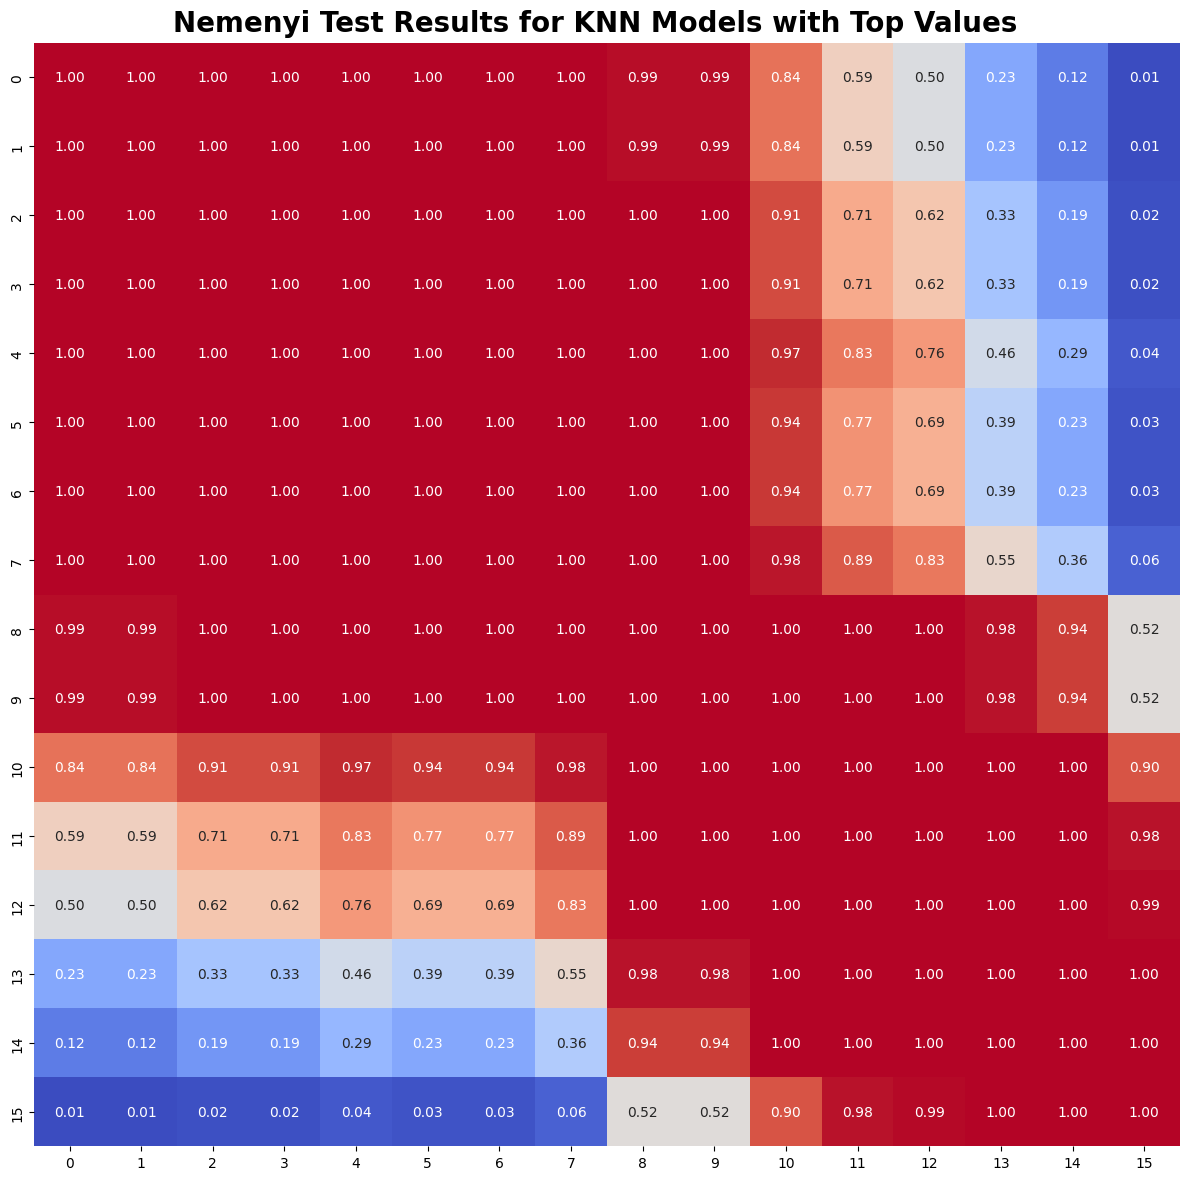

In [15]:

fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(nemenyi_results, fmt='.2f', annot=True, cmap='coolwarm', ax=ax, cbar=False)
fig.suptitle('Nemenyi Test Results for KNN Models with Top Values', fontsize=20, fontweight='bold')
fig.savefig('../reports/figures/nemenyi_test_results_KNN.png', dpi=300)
plt.tight_layout()
plt.show()

In [16]:
def analyze_parameters(df, nemenyi_results):
    # 1. Main Effects Analysis
    print("=== Main Effects ===")
    for param in ['k', 'weighting_func', 'voting_func', 'distance_func']:
        means = df.groupby(param)['mean_f1_score'].mean()
        print(f"\n{param} effects:")
        print(means)
        
    # 2. Interaction Analysis
    print("\n=== Parameter Interactions ===")
    interactions = df.groupby(['k', 'weighting_func', 'voting_func', 'distance_func'])['mean_f1_score'].mean().unstack()
    print(interactions)
    
    # 3. Find Best Combinations
    best_combos = df.nlargest(3, 'mean_f1_score')
    print("\n=== Top 3 Parameter Combinations ===")
    print(best_combos[['k', 'weighting_func', 'voting_func', 'distance_func', 'mean_f1_score']])
    
    # 4. Statistical Significance Summary
    print("\n=== Significant Differences ===")
    alpha = 0.05
    significant_pairs = []
    for i in nemenyi_results.index:
        for j in nemenyi_results.columns:
            if i < j and nemenyi_results.loc[i, j] < alpha:
                significant_pairs.append((i, j, nemenyi_results.loc[i, j]))
    
    for pair in sorted(significant_pairs, key=lambda x: x[2]):
        print(f"{pair[0]} vs {pair[1]}: p={pair[2]:.4f}")


analyze_parameters(models_with_top_values, nemenyi_results)

=== Main Effects ===

k effects:
k
1    0.967217
7    0.927996
Name: mean_f1_score, dtype: float64

weighting_func effects:
weighting_func
EqualWeighting      0.947838
ReliefFWeighting    0.947374
Name: mean_f1_score, dtype: float64

voting_func effects:
voting_func
MajorityClassVote    0.936993
ShepardsWorkVote     0.958220
Name: mean_f1_score, dtype: float64

distance_func effects:
distance_func
ChebyshevDistance    0.938035
EuclideanDistance    0.957177
Name: mean_f1_score, dtype: float64

=== Parameter Interactions ===
distance_func                         ChebyshevDistance  EuclideanDistance
k weighting_func   voting_func                                            
1 EqualWeighting   MajorityClassVote           0.972618           0.969231
                   ShepardsWorkVote            0.972618           0.969231
  ReliefFWeighting MajorityClassVote           0.953228           0.973789
                   ShepardsWorkVote            0.953228           0.973789
7 EqualWeighting   Ma

In [17]:
alpha = 0.05

significant_pairs = []
for i in nemenyi_results.index:
    for j in nemenyi_results.columns:
        if i < j and nemenyi_results.loc[i, j] < alpha:
            significant_pairs.append((i, j, nemenyi_results.loc[i, j]))

significant_pairs_df = models_with_top_values.iloc[list(set(np.array([[pair[0], pair[1]] for pair in significant_pairs]).flatten()))]
significant_pairs_df

,k,distance_func,voting_func,weighting_func,fold1,fold2,fold3,fold4,fold5,fold6,fold7,fold8,fold9,fold10,mean_f1_score,std_f1_score
0,1,EuclideanDistance,MajorityClassVote,ReliefFWeighting,0.814815,1.000000,1.000000,1.00,0.923077,1.000000,1.000000,1.000000,1.00,1.000000,0.973789,0.060865
1,1,EuclideanDistance,ShepardsWorkVote,ReliefFWeighting,0.814815,1.000000,1.000000,1.00,0.923077,1.000000,1.000000,1.000000,1.00,1.000000,0.973789,0.060865
2,1,ChebyshevDistance,MajorityClassVote,EqualWeighting,0.866667,1.000000,0.962963,1.00,0.896552,1.000000,1.000000,1.000000,1.00,1.000000,0.972618,0.049837
3,1,ChebyshevDistance,ShepardsWorkVote,EqualWeighting,0.866667,1.000000,0.962963,1.00,0.896552,1.000000,1.000000,1.000000,1.00,1.000000,0.972618,0.049837
4,7,EuclideanDistance,ShepardsWorkVote,EqualWeighting,0.814815,0.965517,1.000000,1.00,1.000000,1.000000,0.952381,0.960000,1.00,1.000000,0.969271,0.057646
5,1,EuclideanDistance,MajorityClassVote,EqualWeighting,0.769231,1.000000,1.000000,1.00,0.923077,1.000000,1.000000,1.000000,1.00,1.000000,0.969231,0.074315
6,1,EuclideanDistance,ShepardsWorkVote,EqualWeighting,0.769231,1.000000,1.000000,1.00,0.923077,1.000000,1.000000,1.000000,1.00,1.000000,0.969231,0.074315
15,7,ChebyshevDistance,MajorityClassVote,EqualWeighting,0.866667,0.903226,0.896552,0.88,0.896552,0.896552,0.846154,0.888889,0.88,0.888889,0.884348,0.017171
